Попробуем обучить генератор текста на основе данных из сборника русской поэзии. Данные предварительно очищены от некоторых символов и загружены в txt формате на Google Drive. 
План в следующем:
- подготовить словарь из всех встречающихся в тексте слов, где ключом будет слово, значением - уникальный номер
- распилить текст по точкам и выбрать предложения не ниже определённой длины
- каждое предложение преобразовать в последовательность чисел из словаря
- нарезать и сформировать предложения таким образом, чтобы на обучение подавалась только часть текста, а следующее слово нейросеть пыталась предсказать
- обучить нейросеть, используя LSTM (запоминание контекста)
- проверить генерацию


Подключаем гугл диск к среде Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Задаём путь до файла с текстом и открываем его. Также зададим путь для сохранения моделей после каждой эпохи обучения.

In [2]:
PATH = '/content/drive/MyDrive/Colab Notebooks/russkaya_poeziya.txt'
path_model = '/content/drive/MyDrive/path_model'

In [3]:
data = open(PATH, encoding="utf8").read()

In [4]:
data

' \n   Уже бледнеет день, скрываясь за горою;  Шумящие стада толпятся над рекой; Усталый селянин медлительной стопою  Идет, задумавшись, в шалаш спокойный свой. В туманном сумраке окрестность исчезает  Повсюду тишина; повсюду мертвый сон; Лишь изредка, жужжа, вечерний жук мелькает,  Лишь слышится вдали рогов унылый звон. Лишь дикая сова, таясь под древним сводом  Той башни, сетует, внимаема луной, На возмутившего полуночным приходом  Ее безмолвного владычества покой. Под кровом черных сосн и вязов наклоненных,  Которые окрест, развесившись, стоят, Здесь праотцы села, в гробах уединенных  Навеки затворясь, сном непробудным спят. Денницы тихий глас, дня юного дыханье, Ни крики петуха, ни звучный гул рогов, Ни ранней ласточки на кровле щебетанье   Ничто не вызовет почивших из гробов. На дымном очаге трескучий огнь, сверкая, Их в зимни вечера не будет веселить, И дети резвые, встречать их выбегая, Не будут с жадностью лобзаний их ловить. Как часто их серпы златую ниву жали\xa0 И плуг их по

Убираем лишние символы реплейсом и джойном по условию

In [5]:
data1 = data.replace("\n", "")
data1 = data1.replace("\xa0", "")
data1 = ''.join(i for i in data1 if i.isalpha() or i in ['.', ' ', '!', '?'])
data1

'    Уже бледнеет день скрываясь за горою  Шумящие стада толпятся над рекой Усталый селянин медлительной стопою  Идет задумавшись в шалаш спокойный свой. В туманном сумраке окрестность исчезает  Повсюду тишина повсюду мертвый сон Лишь изредка жужжа вечерний жук мелькает  Лишь слышится вдали рогов унылый звон. Лишь дикая сова таясь под древним сводом  Той башни сетует внимаема луной На возмутившего полуночным приходом  Ее безмолвного владычества покой. Под кровом черных сосн и вязов наклоненных  Которые окрест развесившись стоят Здесь праотцы села в гробах уединенных  Навеки затворясь сном непробудным спят. Денницы тихий глас дня юного дыханье Ни крики петуха ни звучный гул рогов Ни ранней ласточки на кровле щебетанье   Ничто не вызовет почивших из гробов. На дымном очаге трескучий огнь сверкая Их в зимни вечера не будет веселить И дети резвые встречать их выбегая Не будут с жадностью лобзаний их ловить. Как часто их серпы златую ниву жали И плуг их побеждал упорные поля! Как часто их с

Заменяем символы конца предложения другим символом, который не встречается. Убираем оставшиеся знаки джойном.

In [6]:
data1 = data1.replace("!", "i")
data1 = data1.replace("?", "i")
data1 = data1.replace(".", "i")
data1 = ''.join(i for i in data1 if i.isalpha() or i == ' ')
data1

'    Уже бледнеет день скрываясь за горою  Шумящие стада толпятся над рекой Усталый селянин медлительной стопою  Идет задумавшись в шалаш спокойный свойi В туманном сумраке окрестность исчезает  Повсюду тишина повсюду мертвый сон Лишь изредка жужжа вечерний жук мелькает  Лишь слышится вдали рогов унылый звонi Лишь дикая сова таясь под древним сводом  Той башни сетует внимаема луной На возмутившего полуночным приходом  Ее безмолвного владычества покойi Под кровом черных сосн и вязов наклоненных  Которые окрест развесившись стоят Здесь праотцы села в гробах уединенных  Навеки затворясь сном непробудным спятi Денницы тихий глас дня юного дыханье Ни крики петуха ни звучный гул рогов Ни ранней ласточки на кровле щебетанье   Ничто не вызовет почивших из гробовi На дымном очаге трескучий огнь сверкая Их в зимни вечера не будет веселить И дети резвые встречать их выбегая Не будут с жадностью лобзаний их ловитьi Как часто их серпы златую ниву жали И плуг их побеждал упорные поляi Как часто их с

Делим текст на предложения по символу, которым замели знаки конца предложения

In [7]:
corpus = data1.lower().split("i")
corpus

['    уже бледнеет день скрываясь за горою  шумящие стада толпятся над рекой усталый селянин медлительной стопою  идет задумавшись в шалаш спокойный свой',
 ' в туманном сумраке окрестность исчезает  повсюду тишина повсюду мертвый сон лишь изредка жужжа вечерний жук мелькает  лишь слышится вдали рогов унылый звон',
 ' лишь дикая сова таясь под древним сводом  той башни сетует внимаема луной на возмутившего полуночным приходом  ее безмолвного владычества покой',
 ' под кровом черных сосн и вязов наклоненных  которые окрест развесившись стоят здесь праотцы села в гробах уединенных  навеки затворясь сном непробудным спят',
 ' денницы тихий глас дня юного дыханье ни крики петуха ни звучный гул рогов ни ранней ласточки на кровле щебетанье   ничто не вызовет почивших из гробов',
 ' на дымном очаге трескучий огнь сверкая их в зимни вечера не будет веселить и дети резвые встречать их выбегая не будут с жадностью лобзаний их ловить',
 ' как часто их серпы златую ниву жали и плуг их побеждал упо

Убираем предложения короче 70 символов. Возможно в более длинных предложениях будет больше смысла за счёт большего кол-ва контекста (но это не точно).

In [8]:
corp = [i for i in corpus if len(i)>70]
corp

['    уже бледнеет день скрываясь за горою  шумящие стада толпятся над рекой усталый селянин медлительной стопою  идет задумавшись в шалаш спокойный свой',
 ' в туманном сумраке окрестность исчезает  повсюду тишина повсюду мертвый сон лишь изредка жужжа вечерний жук мелькает  лишь слышится вдали рогов унылый звон',
 ' лишь дикая сова таясь под древним сводом  той башни сетует внимаема луной на возмутившего полуночным приходом  ее безмолвного владычества покой',
 ' под кровом черных сосн и вязов наклоненных  которые окрест развесившись стоят здесь праотцы села в гробах уединенных  навеки затворясь сном непробудным спят',
 ' денницы тихий глас дня юного дыханье ни крики петуха ни звучный гул рогов ни ранней ласточки на кровле щебетанье   ничто не вызовет почивших из гробов',
 ' на дымном очаге трескучий огнь сверкая их в зимни вечера не будет веселить и дети резвые встречать их выбегая не будут с жадностью лобзаний их ловить',
 ' пускай рабы сует их жребий унижают смеяся в слепоте полезн

Посмотрим длину обучающей выборки. Какая была и какая стала после обработки.

In [9]:
print(len(corpus), len(corp))

7168 3269


Добавим в датасет более короткие предложения, склеив их между собой. Смысл иногда будет теряться, но это же поэзия.

In [10]:
#corp_s = [i for i in corpus if 10<len(i)<70]
#corp_s

Код для склейки 2 коротких кусков в 1 и добавление к общему датасету.

In [11]:
#res = []
#for i in range(0, len(corp_s)-1, 2):
#    res.append(corp_s[i] + corp_s[i + 1])

#for j in res:
#    corp.append(j)
    
#len(corp)

Активируем токенайзер и фитим в него наш текст. В результате получим словарь, где каждому слову присвоен номер в качестве значения. Почему total words+1? Связано с паддингом - добвлением нулевого слова, которого нет в словаре. Падинг - процесс добавления слоя в размерность для сохранения стабильной формы входящих данных.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [11]:
tokenizer.fit_on_texts(corp)
total_words = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
print(total_words)

{'и': 1, 'в': 2, 'не': 3, 'с': 4, 'на': 5, 'я': 6, 'он': 7, 'как': 8, 'ты': 9, 'но': 10, 'что': 11, 'к': 12, 'все': 13, 'мне': 14, 'их': 15, 'а': 16, 'по': 17, 'за': 18, 'от': 19, 'его': 20, 'так': 21, 'из': 22, 'о': 23, 'под': 24, 'то': 25, 'мой': 26, 'ни': 27, 'где': 28, 'у': 29, 'да': 30, 'нет': 31, 'когда': 32, 'там': 33, 'вот': 34, 'ее': 35, 'над': 36, 'во': 37, 'для': 38, 'мы': 39, 'меня': 40, 'лишь': 41, 'уж': 42, 'она': 43, 'без': 44, 'нам': 45, 'был': 46, 'ней': 47, 'нас': 48, 'ли': 49, 'твой': 50, 'тебя': 51, 'же': 52, 'здесь': 53, 'наш': 54, 'тут': 55, 'тебе': 56, 'моей': 57, 'кто': 58, 'свой': 59, 'только': 60, 'жизнь': 61, 'еще': 62, 'ним': 63, 'со': 64, 'до': 65, 'жизни': 66, 'чтоб': 67, 'им': 68, 'пред': 69, 'всех': 70, 'вы': 71, 'иль': 72, 'они': 73, 'ж': 74, 'ей': 75, 'час': 76, 'нем': 77, 'ему': 78, 'друг': 79, 'бы': 80, 'любви': 81, 'день': 82, 'себе': 83, 'них': 84, 'сердце': 85, 'ль': 86, 'бог': 87, 'один': 88, 'свет': 89, 'при': 90, 'есть': 91, 'сердца': 92, 'пуст

Создаём пустой список, в котором будут содержаться обучающие данные. К каждой строке в наших данных применяем токенайзер последовательности, переводя строки с текстом в списки чисел.
Затем перебираются все числа списка, начиная с первого, к которому добавляется следующее в списке число. Затем пара добавляется в пустой список input_sequences в виде подсписка. Потом к этим двум числам добавляется третье и добавляется в input_sequences. И так далее, пока не кончатся числа в строке. Затем цикл переходит к следующей строке.
Делается это для того, чтобы получить последовательности добавления слов один за другим для обучения сети.

In [12]:
input_sequences = []
for line in corp:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

Тут мы находим самый длинный подсписок в input_sequences и заполняем остальные списки нулями до длины самого длинного подсписка. Делается это, чтобы сохранить нужную форму входящих в нейросеть данных. Нули ставим перед числами. Саму форму данных вытягиваем в массив-матрицу.

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Срезами делим нашу массив-матрицу на фичи (слова, предшествующие следующему слову) и лэйблы (следующее слово). Форма массива такова, что лэйблы всегда последние в каждой последовательности, а фичи - всё, кроме последнего значения.

In [14]:
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

Тут нужно указать, что лэйблы - это категориальные значения. Теперь каждое число - лэйбл будет соответствовать порядковому номеру в списке нулей, длиной равной числу лэйблов. Значение лэйбла на своей позиции будет равно 1. Требуется для "понимания" алгоритмом того, что 3 не больше, чем 2, а это [0, 0, 1,...] и [0, 1, 0,...]   

In [15]:
import tensorflow as tf
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Создадим модель нейросети. Последовательность из слоёв: Входящи - Embedding с параметрами (число слов в словаре, число нейронов на выходе, длина строки (последнее значение - это лэйбл в исходной строке, поэтому -1)). Слой LSTM, для запоминания нейросетью контекста предыдущих слов. И слой нейронов, числом равным длине словаря и функцией активации софтмакс. Задаём также оптимизатор, шаг сходимости, функцию потерь, метрику при обучении. Фитим на 100 эпох. Ждём. 
Пока ждём нужно сказать, что гиперпарамтеры нейросети (от функций активации до числа эпох и слоёв) - настраиваемые. Лучшая конфигурация определяется опытным путём. Обучение длится часами, даже для такого небольшого количества слов и строк. Поэтому была попробована только 1 конфигурация. Естественно, можно сделать лучше, если есть время.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(total_words, 220, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200, stateful=False)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

Код для сохранения модели после каждой эпохи.

In [17]:
metric = 'accuracy'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= path_model, monitor=metric,
                                                         save_best_only=True)

In [21]:
from keras.models import save_model, load_model
model = load_model(path_model)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

In [20]:
history = model.fit(xs, ys, epochs=20, callbacks= [checkpoint_callback], verbose=1)
print(model)

Epoch 1/20
 919/2107 [============>.................] - ETA: 15:41 - loss: 4.6757 - accuracy: 0.2919

KeyboardInterrupt: ignored

Отрисуем историю обучения.

In [55]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

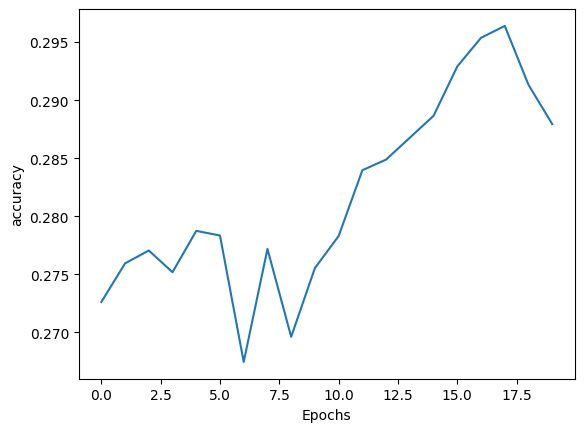

In [56]:
plot_graphs(history, 'accuracy')

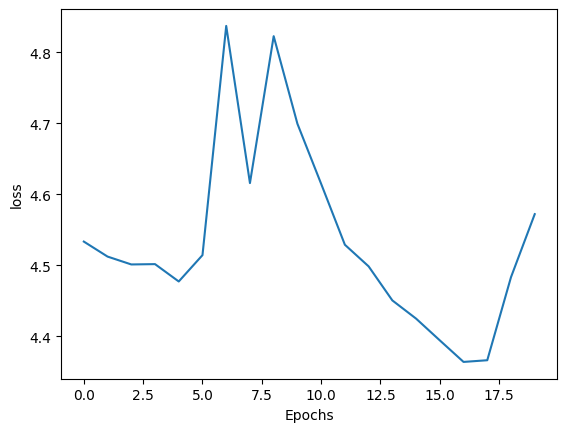

In [57]:
plot_graphs(history, 'loss')

Вспомогательная функция для генерации. Она задаёт правила выбора значения из массива предсказанных значений. Другими словами, при предсказании создаётся массив вероятностей следующего слова. Если всегда брать большую вероятность, то мы получим зацикливание текста. Эта функция помогает несколько зарандомить выбор. В зависимости от параметра temperature (0.2-1.2) мы можем получить более распространённые слова или менее распространённые.

In [22]:
def sample(preds, temperature=1.2):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Сгенерируем текст по первым словам. Для этого зададим начальный текст, число следующих слов. Создаём цикл по числу предсказываемых слов, в котором каждую итерацию текст, перед предсказываемым словом будет проходить предобработку и предикт. Затем полученный предикт будет сравниваться со всеми значениями из словаря и при совпадении добавлятся в начальный текст. Затем начальный текст будет заново подаваться в цикл. Таким образом на выходе мы получим seed_text + 40 предсказанных слов.

In [36]:
prediction_model = model
seed_text = "Не мысля гордый свет забавить вниманье дружбы"
next_words = 20
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	preds = prediction_model.predict(token_list)[0]
	predicted = sample(preds, 1.2)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 51ms/step


<ipython-input-22-132183c2c2f6>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


1/1 [==============================] - 0s 59ms/step
Не мысля гордый свет забавить вниманье дружбы веял ветерок насилу россию как крылами небес но мне закон что чернеет в тишине на уж западных опять девица меду
